In [194]:
import numpy as np
import pandas as pd
import scipy as sc
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

from sklearn.linear_model.logistic import LogisticRegression
from sklearn.pipeline import Pipeline
from pyearth import Earth, export

## Examples

**Library:** py-earth http://contrib.scikit-learn.org/py-earth/

**Installing: **
* git clone git://github.com/scikit-learn-contrib/py-earth.git
* cd py-earth
* python setup.py install

### Comparing different classification methods

Here the last method consists of earth model and logistic regression stages.

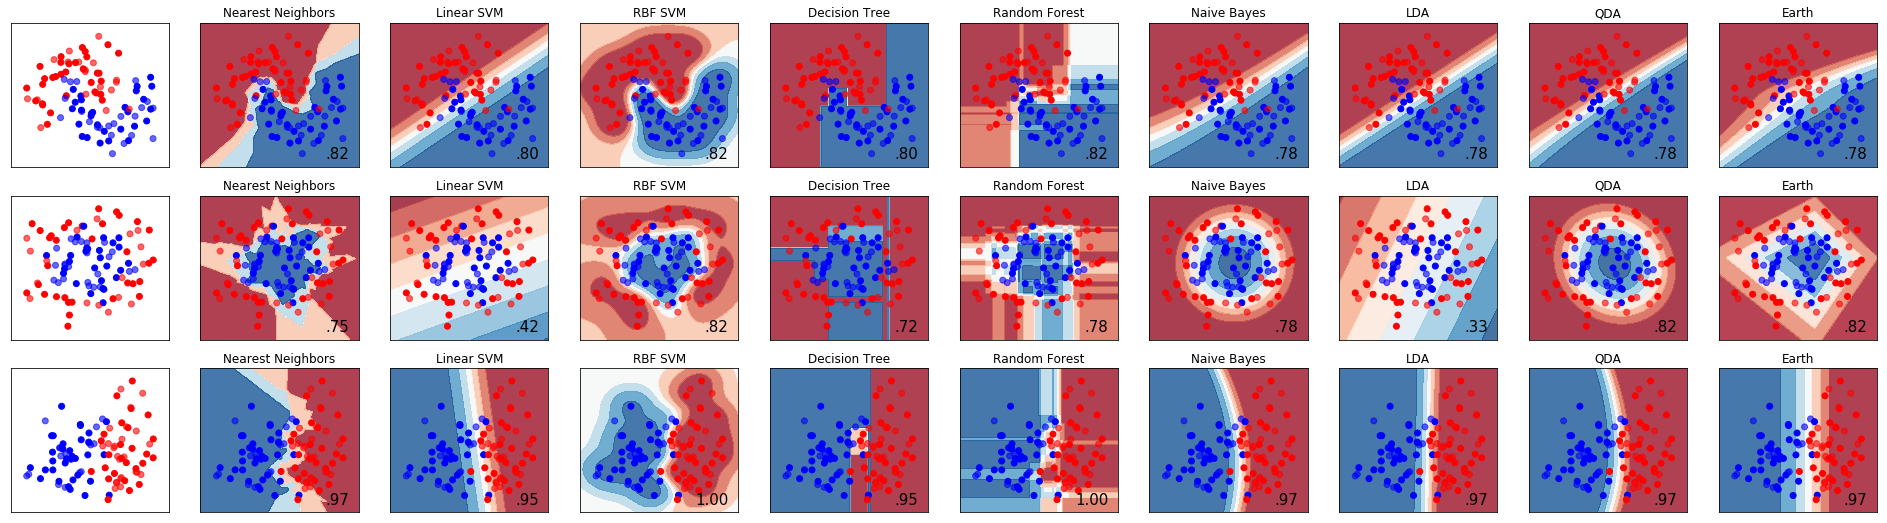

In [195]:
h = .02  # step size in the mesh

np.random.seed(1)

# Combine Earth with LogisticRegression in a pipeline to do classification
earth_classifier = Pipeline([('earth', Earth(max_degree=3, penalty=1.5)),
                             ('logistic', LogisticRegression())])

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Decision Tree",
         "Random Forest", "Naive Bayes", "LDA", "QDA", "Earth"]
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025, probability=True),
    SVC(gamma=2, C=1, probability=True),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    GaussianNB(),
    LDA(),
    QDA(),
    earth_classifier]

X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [make_moons(noise=0.3, random_state=0),
            make_circles(noise=0.2, factor=0.5, random_state=1),
            linearly_separable
            ]

figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets
for ds in datasets:
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
    # and testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, m_max]x[y_min, y_max].
        try:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
        except NotImplementedError:
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot also the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
        # and testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                   alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_title(name)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
        i += 1

figure.subplots_adjust(left=.02, right=.98)
plt.savefig('classifier_comp.pdf', transparent=True)
plt.show()

Model summary shows the basis functions that we choose and their coefficients. 'Pruned' parameter tells whether this function weas pruned at backward stage.

In [197]:
print clf.named_steps['earth'].summary()

Earth Model
-------------------------------------------------------------------
Basis Function                                Pruned  Coefficient  
-------------------------------------------------------------------
(Intercept)                                   No      0.99372      
h(x0+0.855691)                                No      -0.655377    
h(-0.855691-x0)                               Yes     None         
h(x0-0.541112)*h(x0+0.855691)                 No      0.238215     
h(0.541112-x0)*h(x0+0.855691)                 Yes     None         
h(x1-1.112)*h(0.541112-x0)*h(x0+0.855691)     No      21.8165      
h(1.112-x1)*h(0.541112-x0)*h(x0+0.855691)     Yes     None         
h(x0-0.342241)*h(0.541112-x0)*h(x0+0.855691)  No      120.662      
h(0.342241-x0)*h(0.541112-x0)*h(x0+0.855691)  Yes     None         
h(x0-0.214806)*h(0.541112-x0)*h(x0+0.855691)  No      -13.0165     
h(0.214806-x0)*h(0.541112-x0)*h(x0+0.855691)  No      0.79254      
------------------------------------

### 2-dimensional outcome

Earth Model
------------------------------------------------------
Basis Function  Pruned  Coefficient 0  Coefficient 1  
------------------------------------------------------
(Intercept)     No      -61.0212       802.391        
h(x6+22.333)    Yes     None           None           
h(-22.333-x6)   No      -6.25313       73.1045        
h(x6-19.7177)   Yes     None           None           
h(19.7177-x6)   No      15.9809        -1.57574       
h(x9+19.5183)   Yes     None           None           
h(-19.5183-x9)  Yes     None           None           
h(x6+27.5244)   Yes     None           None           
h(-27.5244-x6)  No      -0.0793942     -48.7354       
h(x6+15.7563)   No      9.75984        0.331824       
h(-15.7563-x6)  No      -17.3782       -72.5691       
h(x6+11.4701)   Yes     None           None           
h(-11.4701-x6)  No      -1.26613       38.2752        
h(x5-22.0638)   No      0.108558       4.6959         
h(22.0638-x5)   Yes     None           None          

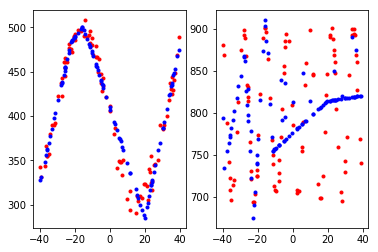

Resulting sympy expression:
[0.108557619050281*Max(0, x5 - 22.0638328977239) - 0.0793941674141255*Max(0, -x6 - 27.5244390031189) - 6.25312667318507*Max(0, -x6 - 22.332966795083) - 17.3782056914152*Max(0, -x6 - 15.756301752476) - 1.26613029580261*Max(0, -x6 - 11.4700575101793) + 15.9809280547726*Max(0, -x6 + 19.7177285698951) + 9.75983992057412*Max(0, x6 + 15.756301752476) - 61.0212330985022, 4.69589743643032*Max(0, x5 - 22.0638328977239) - 48.7354137627313*Max(0, -x6 - 27.5244390031189) + 73.1045149556454*Max(0, -x6 - 22.332966795083) - 72.5691388861474*Max(0, -x6 - 15.756301752476) + 38.275226784937*Max(0, -x6 - 11.4700575101793) - 1.57574324788202*Max(0, -x6 + 19.7177285698951) + 0.331823789432142*Max(0, x6 + 15.756301752476) + 802.390987547143]


In [198]:
# Create some fake data
np.random.seed(2)
m = 100
n = 10
X = 80 * np.random.uniform(size=(m, n)) - 40
y1 = 100 *  np.abs(np.sin((X[:, 6]) / 10) - 4.0) + 10 * np.random.normal(size=m)

y2 = 100 * np.abs(np.sin((X[:, 6]) / 2) - 8.0) + 5 * np.random.normal(size=m)

# Fit an Earth model
model = Earth(max_degree=1, minspan_alpha=.5)
y_mix = np.concatenate((y1[:, np.newaxis], y2[:, np.newaxis]), axis=1)
model.fit(X, y_mix)

# Print the model
#print(model.trace())
print(model.summary())

# Plot the model
y_hat = model.predict(X)

fig = plt.figure()

ax = fig.add_subplot(1, 2, 1)
ax.plot(X[:, 6], y_mix[:, 0], 'r.')
ax.plot(X[:, 6], model.predict(X)[:, 0], 'b.')

ax = fig.add_subplot(1, 2, 2)
ax.plot(X[:, 6], y_mix[:, 1], 'r.')
ax.plot(X[:, 6], model.predict(X)[:, 1], 'b.')
plt.show()

print('Resulting sympy expression:')
print(export.export_sympy(model))

## Time series

In [199]:
data_uschad = pd.read_table("../data/USC-HAD/USC-HAD_cleared.txt", 
                            delimiter=',', header=None)
data_uschad.columns = ['id_user', 'activity', 'timestamp', 'x', 'y', 'z']

data_wisdm = pd.read_table("../data/WISDM/WISDM_ar_v1.1_raw_cleared.txt", 
                           delimiter=',', header=None)
data_wisdm.columns = ['id_user', 'activity', 'timestamp', 'x', 'y', 'z']

In [200]:
def check_candidate(candidate, data_type, threshold=2.*1e8):
    if data_type == "USCHAD":
        threshold = 0.
    tsp = np.array(candidate['timestamp'])
    diffs = tsp[1:] - tsp[:-1]
    
    return np.sum(diffs > threshold) == 0

def get_time_series(accelerations, data_type, nb=200):
    accelerations.index = [i for i in range(len(accelerations))]
    TS = []
    st = 0
    fi = st + nb
    while fi < len(accelerations):
        candidate = accelerations.loc[[st + i for i in range(nb)], :]
        if check_candidate(candidate, data_type):
            TS.append([np.array(candidate['x']), 
                       np.array(candidate['y']), 
                       np.array(candidate['z'])])
        st = fi
        fi += nb
    
    return TS

In [292]:
def get_matrix(data, data_type, axis=0):
    """
    Function gives the design matrix of raw time seties.
    Input:
    - data - initial dataset
    - data_type - string such as 'WISDM' or 'USC-HAD' specifies the data
    Output:
    - df - [n_objects x 1+ts_length] the matrix whose rows contains activity label and 
           time series with length of 200 points.
    """
    
    classes = list(set(data['activity']))
    
    df = []

    id_range = np.unique(np.array(data['id_user']))
    for id_user in id_range:
        for activity in classes:
            mask = (data.loc[:, 'id_user'] == id_user) & (data.loc[:, 'activity'] == activity)
            accelerations = data.loc[mask, ['timestamp', 'x', 'y', 'z']].copy()
            TS = get_time_series(accelerations, data_type, nb=200)
            for ts in TS:
                df.append([classes.index(activity)] + ts[axis].tolist())
    
    df = pd.DataFrame(df)
    df.rename(columns={0: 'Activity'}, inplace=True)
    return df

In [322]:
def get_submatrix(df, m=100, T=50, index=None):
    """
    Function randomly selects m rows from df without replacement 
    and picks first T points of each ts.
    Input:
    - df - dataframe
    - m - amount of objects we would like to select
    - T - number of ts points
    Output:
    - subdf - [m, 1+T] dataframe whose rows contains activity label and 
           time series with length of T points.
    """
    if index is None:
        subdf = df.iloc[np.random.choice(n_objects, m, replace=False), :T+1]
    else:
        subdf = df.iloc[index, :T+1]
    
    return subdf

In [230]:
df = get_matrix(data_wisdm, 'WISDM', axis=0)
n_objects, n_features = df.shape[0], df.shape[1]-1
print n_objects, n_features

idx = np.random.choice(n_objects, m, replace=False)

4321 200


In [287]:
T = int(n_features / 2)
m = int(n_objects / 10)

subdf = get_submatrix(df, m, T)
y = subdf['Activity'].values
X = subdf.drop(['Activity'], axis=1).values
X.shape

(432, 100)

In [317]:
t = np.arange(0, T)[:, np.newaxis]

model = Earth(max_degree=3, minspan=20, max_terms=min(T/2, (2 * T + m) // 5), 
              penalty=0.01, verbose=True)
model.fit(t, X.T)

Beginning forward pass
-----------------------------------------------------------------
iter  parent  var  knot  mse        terms  gcv     rsq    grsq   
-----------------------------------------------------------------
0     -       -    -     30.665059  1      31.288  0.000  0.000  
1     0       0    -1    30.535916  2      31.798  0.004  -0.016  
2     0       0    92    30.217893  4      32.799  0.015  -0.048  
3     2       0    -1    29.652227  5      32.869  0.033  -0.051  
4     4       0    -1    29.085396  6      32.934  0.052  -0.053  
5     0       0    8     28.788959  8      34.039  0.061  -0.088  
6     7       0    -1    28.256156  9      34.152  0.079  -0.092  
7     8       0    -1    27.593876  10     34.101  0.100  -0.090  
8     0       0    29    27.476904  12     35.526  0.104  -0.135  
9     11      0    -1    27.194527  13     35.978  0.113  -0.150  
10    12      0    -1    26.709850  14     36.169  0.129  -0.156  
11    12      0    8     26.496627  16     

Earth(allow_linear=None, allow_missing=False, check_every=None,
   enable_pruning=True, endspan=None, endspan_alpha=None, fast_K=None,
   fast_h=None, feature_importance_type=None, max_degree=3, max_terms=50,
   min_search_points=None, minspan=20, minspan_alpha=None, penalty=0.01,
   smooth=None, thresh=None, use_fast=None, verbose=True, zero_tol=None)

### Result of approximation

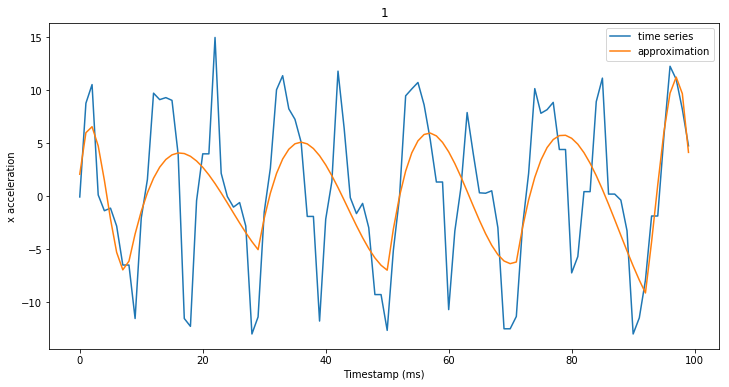

In [318]:
i = 30
x_hat = model.predict(t)[:, i]
plt.figure(figsize=(12, 6))
plt.plot(X[i, :], label='time series')
plt.plot(x_hat, label='approximation')
plt.title(y[i])
plt.xlabel('Timestamp (ms)')
plt.ylabel('x acceleration')
plt.legend()
plt.show()

In [319]:
df_mars_wisdm = pd.DataFrame(model.coef_)
df_mars_wisdm['activity'] = y
df_mars_wisdm.to_csv("../data/features/mars_wisdm.csv", index=False)

In [320]:
df_mars_wisdm.shape

(432, 52)

In [324]:
idx = np.random.choice(n_objects, m, replace=False)
T = int(n_features / 2)
m = int(n_objects / 10)
t = np.arange(0, T)[:, np.newaxis]
df_mars_wisdm = pd.DataFrame(y, columns=['activity'])

model = Earth(max_degree=3, minspan=20, max_terms=min(T/2, (2 * T + m) // 5), 
              penalty=0.01, verbose=True)

for axis in range(3):
    df = get_matrix(data_wisdm, 'WISDM', axis=axis)
    
    subdf = get_submatrix(df, m, T, idx)
    y = subdf['Activity'].values
    X = subdf.drop(['Activity'], axis=1).values
    
    model.fit(t, X.T)
    df_mars_wisdm = pd.concat([df_mars_wisdm, pd.DataFrame(model.coef_)], axis=1)
    print 'Number of features for axis %d: %d' % (axis, model.coef_.shape[1])

Beginning forward pass
-----------------------------------------------------------------
iter  parent  var  knot  mse        terms  gcv     rsq    grsq   
-----------------------------------------------------------------
0     -       -    -     22.313107  1      22.766  0.000  0.000  
1     0       0    -1    22.205237  2      23.123  0.005  -0.016  
2     0       0    92    21.951005  4      23.826  0.016  -0.047  
3     2       0    -1    21.535289  5      23.872  0.035  -0.049  
4     4       0    -1    21.150430  6      23.949  0.052  -0.052  
5     0       0    8     20.934559  8      24.752  0.062  -0.087  
6     1       0    8     20.373361  10     25.177  0.087  -0.106  
7     9       0    -1    19.943968  11     25.207  0.106  -0.107  
8     3       0    -1    19.733380  12     25.514  0.116  -0.121  
9     3       0    71    19.250411  14     26.068  0.137  -0.145  
10    3       0    29    19.044488  16     27.039  0.146  -0.188  
11    12      0    -1    18.808839  17     

In [325]:
df_mars_wisdm.to_csv("../data/features/mars_wisdm.csv", index=False)